# Tsunami Prediction - MDS Datathon (Winner)

This notebook presents my winning solution for the **2025 UBC MDS Tsunami Prediction Datathon**.  
The competition objective was to build a machine learning model that predicts whether an earthquake would trigger a tsunami based on seismic and geographic features.

## 1. Executive Summary

This project combines machine learning with geospatial feature engineering to improve tsunami prediction accuracy

### Key Contributions
- Engineered geo-spatial features from raw latitude and longitude, including:
  - Distance to coastline (via Mercator-projected nearest-boundary calculation)
  - A classification of whether an earthquake happens under the land or sea
  - A tectonic plate each earthquake belongs to using PB2002 plate polygons
- Visualized data points along with earth map and tectonic plates to extract meaningful spatial insights
- Applied a structured machine learning workflow including:
  - Column Transformer: Scaling & OneHotEncoder
  - Cross-validated model comparison across 7 different ML algorithms
  - Hyperparameter tuning with RandomizedCV
- Selected a tuned Random Forest model achieving 0.87 ROC-AUC on CV
  
### Why This Solution Won
Although other teams achieved slightly higher raw accuracy scores, this solution stood out for:
- Strong understanding of earthquakes and how to predict tsunami leveraging geosciences domain knowledge
- Strong feature engineering
- Clear explanation of why raw latitude/longitude can cause overfitting 
- Clean geospatial transformations grounded in real-world tsunami dynamics  
- Transparent and interpretable modeling steps  

This notebook has been cleaned and expanded after the competition to improve clarity and reproducibility.
The competition submission itself was created under a 3-hour time limit.

## 2. Import Datasets & Libraries

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import altair_ally as aly

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import loguniform, randint
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# For Lat and Long Data Preprocessing
import geopandas as gpd
from shapely.geometry import Point
import geodatasets
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Load the datasets
test_df = pd.read_csv("../data/test.csv")
train_df = pd.read_csv("../data/train.csv")

## 3. Data Visualization

In [3]:
# Codes for visualizing data points along with plate boundaries on the map 
# colored by a numeric feature
def plot_map_numeric(df, value_col, lon_col="longitude", lat_col="latitude",
                     cmap="viridis", markersize=6, title=None):
    """
    Plot latitude/longitude points on a world map colored by a NUMERICAL column.
    """
    plate_boundaries_url = "https://raw.githubusercontent.com/fraxen/tectonicplates/master/GeoJSON/PB2002_boundaries.json"
    plates = gpd.read_file(plate_boundaries_url)
    plates = plates.to_crs("EPSG:4326")
    
    fig = plt.figure(figsize=(14, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Background
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    
    # Plot plate boundaries
    plates.plot(ax=ax, color="grey", linewidth=1, transform=ccrs.PlateCarree())

    # Scatter with continuous colormap
    sc = ax.scatter(
        df[lon_col],
        df[lat_col],
        c=df[value_col],
        cmap=cmap,
        s=markersize,
        transform=ccrs.PlateCarree()
    )

    # Colorbar
    cbar = plt.colorbar(sc, shrink=0.6)
    cbar.set_label(value_col, fontsize=12)

    # Title
    if title is None:
        title = f"Map Colored by Numerical Variable '{value_col}'"
    plt.title(title, fontsize=16)

    plt.show()

In [4]:
# Codes for visualizing data points along with plate boundaries on the map 
# colored by a categorical feature
def plot_map_categorical(df, category_col, lon_col="longitude", lat_col="latitude",
                         cmap="tab20", markersize=6, title=None):
    """
    Plot latitude/longitude points on a world map colored by a CATEGORICAL column.
    Automatically assigns colors using factorize().
    """
    plate_boundaries_url = "https://raw.githubusercontent.com/fraxen/tectonicplates/master/GeoJSON/PB2002_boundaries.json"
    plates = gpd.read_file(plate_boundaries_url)
    plates = plates.to_crs("EPSG:4326")
   
    # Convert categories → integer IDs
    cat_codes, uniques = pd.factorize(df[category_col])

    fig = plt.figure(figsize=(14, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Background
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    # Plot plate boundaries
    plates.plot(ax=ax, color="grey", linewidth=1, transform=ccrs.PlateCarree())

    # Scatter with discrete colormap
    sc = ax.scatter(
        df[lon_col],
        df[lat_col],
        c=cat_codes,
        cmap=cmap,
        s=markersize,
        transform=ccrs.PlateCarree()
    )

    # Categorical colorbar labels
    cbar = plt.colorbar(sc, shrink=0.6, ticks=range(len(uniques)))
    cbar.ax.set_yticklabels(uniques)
    cbar.set_label(category_col, fontsize=12)

    # Title
    if title is None:
        title = f"Map Colored by Categorical Variable '{category_col}'"
    plt.title(title, fontsize=16)

    plt.show()

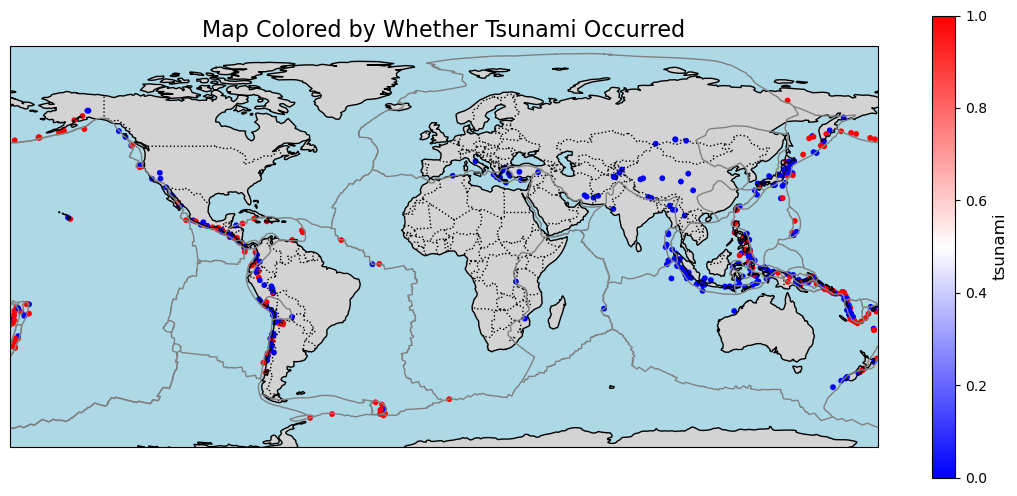

In [27]:
plot_map_numeric(train_df, "tsunami", lon_col="longitude", lat_col="latitude",
                     cmap="bwr", markersize=10, title="Map Colored by Whether Tsunami Occurred")

## 4. Geospatial Feature Engineering

If we use latitude and longitude directly, it can lead the model to overfit. For a tsunami to happen, it is likel to be associated with whether an earthquake happens under the sea, how far away it is from the coast, and the tectonic plate where an earthquake happens. Therefore, these transformations need to be done to account for that.

In [6]:
# Load Natural Earth low-res land polygons via geodatasets
world_path = geodatasets.get_path("naturalearth.land")
land = gpd.read_file(world_path)

# Convert your lat/lon into point geometry
train_df['geometry'] = train_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Make GeoDataFrame
gdf = gpd.GeoDataFrame(train_df, geometry='geometry', crs="EPSG:4326")

# Spatial join: which points intersect land?
joined = gpd.sjoin(gdf, land, how='left', predicate='intersects')

# If land data missing → ocean
train_df['is_under_sea'] = joined['featurecla'].isna().astype(int)

# Drop geometry if not needed
train_df = train_df.drop(columns=['geometry'])
train_df

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,is_under_sea
0,6.9,0,6,732,117,0.000,0.0,28.00,-4.0220,101.7760,2001,1,0,1
1,6.8,0,5,711,64,0.000,0.0,33.00,6.6310,126.8990,2001,1,0,1
2,7.2,4,4,838,443,0.000,17.0,19.00,2.4330,93.2100,2012,1,0,1
3,6.5,0,6,650,700,0.000,47.4,43.00,51.1480,157.5220,2006,8,0,1
4,6.6,8,8,831,782,0.000,16.7,12.00,37.5350,138.4460,2007,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,6.6,9,8,2840,0,0.174,25.0,8.00,42.8621,13.0961,2016,10,0,0
543,7.0,4,7,768,537,0.000,23.1,22.00,-2.1300,99.6270,2007,9,0,1
544,7.8,9,9,1545,0,0.481,21.0,15.11,-42.7373,173.0540,2016,11,1,0
545,6.5,7,7,756,178,0.430,54.0,10.00,23.0290,121.3480,2022,9,1,1


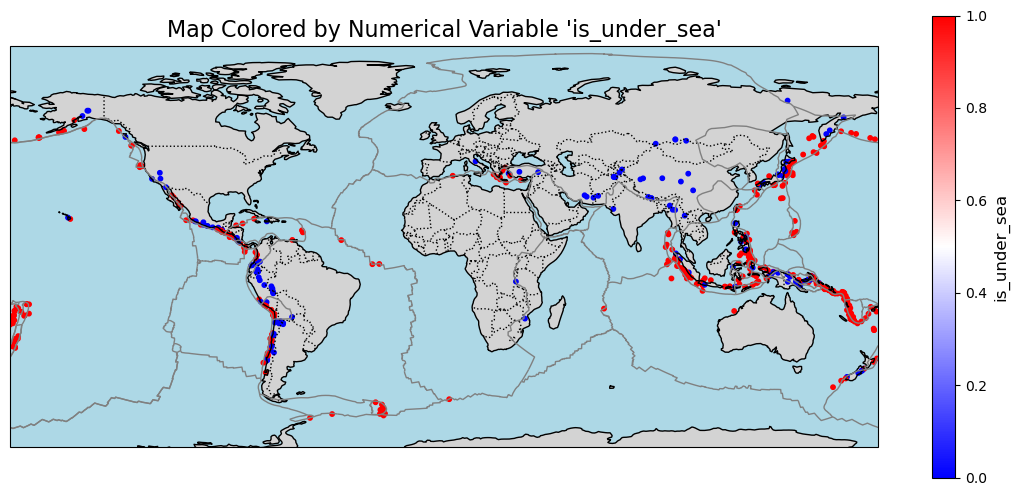

In [7]:
plot_map_numeric(train_df, "is_under_sea", lon_col="longitude", lat_col="latitude",
                     cmap="bwr", markersize=10, title=None)

In [8]:
# Load Natural Earth land polygons
land_path = geodatasets.get_path("naturalearth.land")
land = gpd.read_file(land_path)

# Convert to coastline by taking the boundary
coast = land.boundary

# Project to world mercator (meters)
coast = coast.to_crs(epsg=3395)

def compute_distance_to_coast(row):
    # lon, lat → point
    point = Point(row["longitude"], row["latitude"])

    # project point to mercator
    point_m = gpd.GeoSeries([point], crs="EPSG:4326").to_crs(epsg=3395)[0]

    # shortest coastline distance
    dist_m = coast.distance(point_m).min()

    return dist_m / 1000  # convert to km

train_df["distance_to_coast_km"] = train_df.apply(compute_distance_to_coast, axis=1)
train_df

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,is_under_sea,distance_to_coast_km
0,6.9,0,6,732,117,0.000,0.0,28.00,-4.0220,101.7760,2001,1,0,1,60.669494
1,6.8,0,5,711,64,0.000,0.0,33.00,6.6310,126.8990,2001,1,0,1,59.417189
2,7.2,4,4,838,443,0.000,17.0,19.00,2.4330,93.2100,2012,1,0,1,368.904911
3,6.5,0,6,650,700,0.000,47.4,43.00,51.1480,157.5220,2006,8,0,1,41.799492
4,6.6,8,8,831,782,0.000,16.7,12.00,37.5350,138.4460,2007,7,0,0,1.407555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,6.6,9,8,2840,0,0.174,25.0,8.00,42.8621,13.0961,2016,10,0,0,88.747587
543,7.0,4,7,768,537,0.000,23.1,22.00,-2.1300,99.6270,2007,9,0,1,128.815297
544,7.8,9,9,1545,0,0.481,21.0,15.11,-42.7373,173.0540,2016,11,1,0,35.013012
545,6.5,7,7,756,178,0.430,54.0,10.00,23.0290,121.3480,2022,9,1,1,8.772963


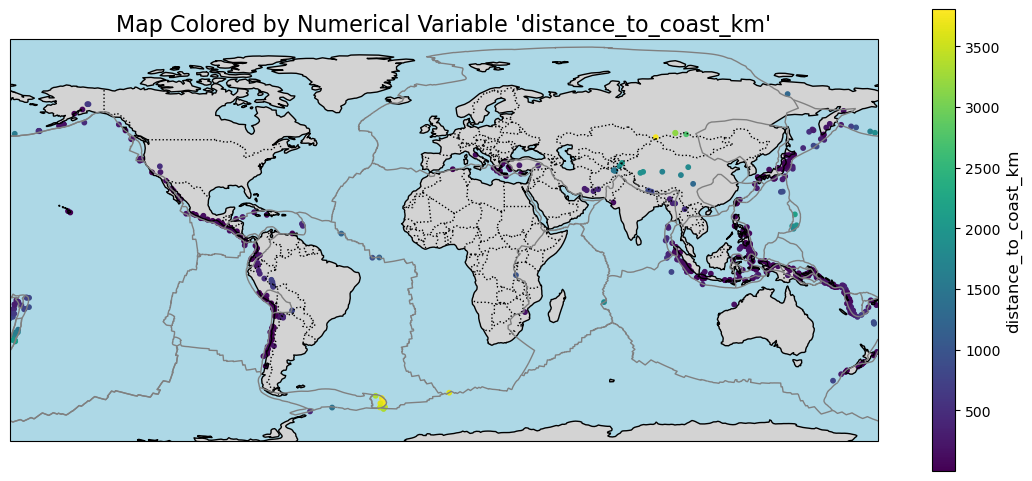

In [9]:
plot_map_numeric(train_df, "distance_to_coast_km", lon_col="longitude", lat_col="latitude",
                     cmap="viridis", markersize=10, title=None)

In [10]:
plate_polygons_url = "https://raw.githubusercontent.com/fraxen/tectonicplates/master/GeoJSON/PB2002_plates.json"
plates = gpd.read_file(plate_polygons_url)

plates = plates.to_crs("EPSG:4326")   # ensure lat/long CRS

gdf = gpd.GeoDataFrame(
    train_df,
    geometry=gpd.points_from_xy(train_df["longitude"], train_df["latitude"]),
    crs="EPSG:4326"
)

train_df = gpd.sjoin(gdf, plates, predicate="within", how="left")
train_df = train_df.drop(columns=['geometry', 'index_right','LAYER', 'Code'])
train_df

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami,is_under_sea,distance_to_coast_km,PlateName
0,6.9,0,6,732,117,0.000,0.0,28.00,-4.0220,101.7760,2001,1,0,1,60.669494,Sunda
1,6.8,0,5,711,64,0.000,0.0,33.00,6.6310,126.8990,2001,1,0,1,59.417189,Sunda
2,7.2,4,4,838,443,0.000,17.0,19.00,2.4330,93.2100,2012,1,0,1,368.904911,India
3,6.5,0,6,650,700,0.000,47.4,43.00,51.1480,157.5220,2006,8,0,1,41.799492,Okhotsk
4,6.6,8,8,831,782,0.000,16.7,12.00,37.5350,138.4460,2007,7,0,0,1.407555,Okhotsk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,6.6,9,8,2840,0,0.174,25.0,8.00,42.8621,13.0961,2016,10,0,0,88.747587,Eurasia
543,7.0,4,7,768,537,0.000,23.1,22.00,-2.1300,99.6270,2007,9,0,1,128.815297,Sunda
544,7.8,9,9,1545,0,0.481,21.0,15.11,-42.7373,173.0540,2016,11,1,0,35.013012,Pacific
545,6.5,7,7,756,178,0.430,54.0,10.00,23.0290,121.3480,2022,9,1,1,8.772963,Philippine Sea


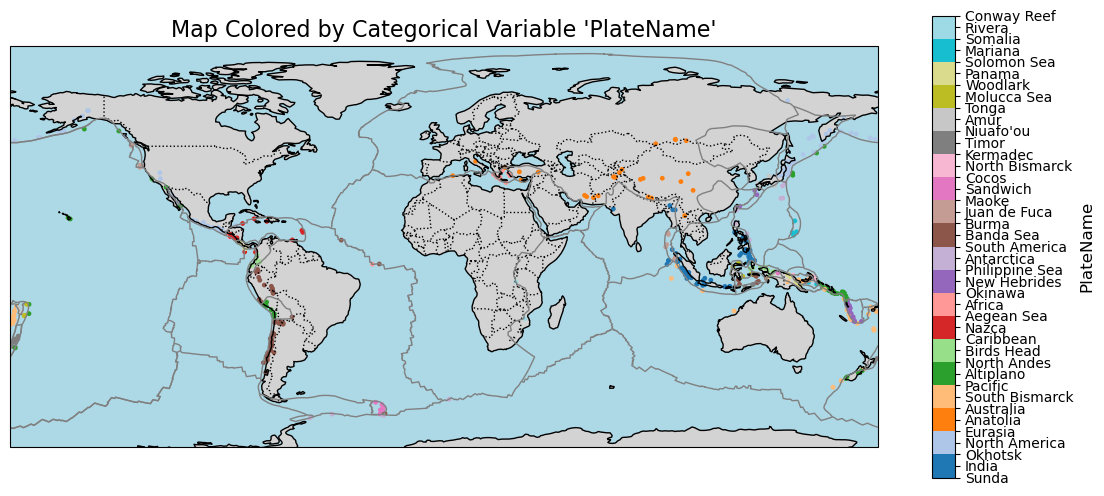

In [11]:
plot_map_categorical(train_df, "PlateName", lon_col="longitude", lat_col="latitude",
                         cmap="tab20", markersize=6, title=None)

## 5. EDA

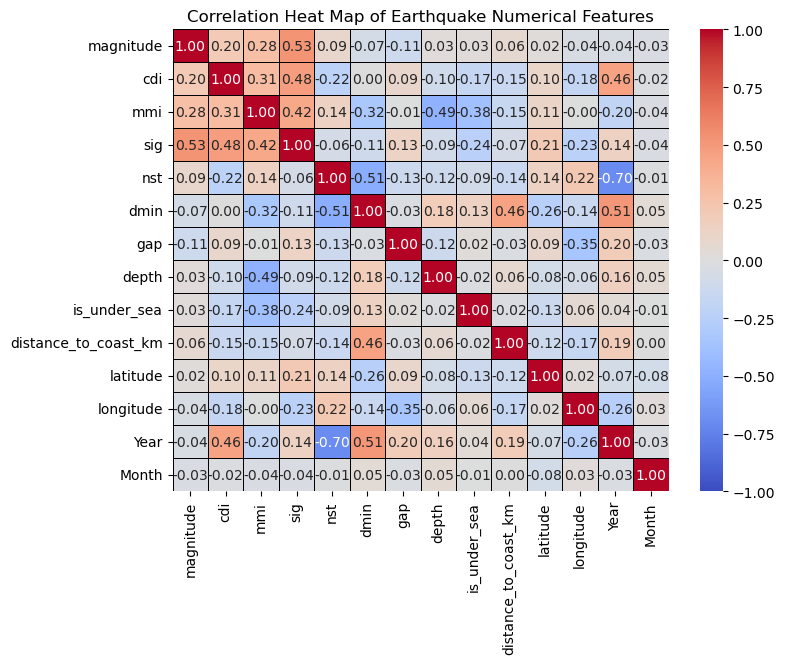

In [30]:
# The 12 original numerical predictor features
numerical_features = [
    'magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'is_under_sea', 'distance_to_coast_km',
    'latitude', 'longitude', 'Year', 'Month'
]
corr_df = train_df[numerical_features]

# --- 3. Calculate Correlation Matrix ---
# Calculate the correlation matrix for the selected columns
correlation_matrix = corr_df.corr()

# --- 4. Generate Heat Map ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,        # Display correlation values
    cmap='coolwarm',   # Use a diverging color map
    fmt=".2f",         # Format numbers to two decimal places
    linewidths=0.5,    # Add lines between cells
    vmin=-1,
    vmax=1,
    linecolor='black'
)
plt.title('Correlation Heat Map of Earthquake Numerical Features')
plt.show() #

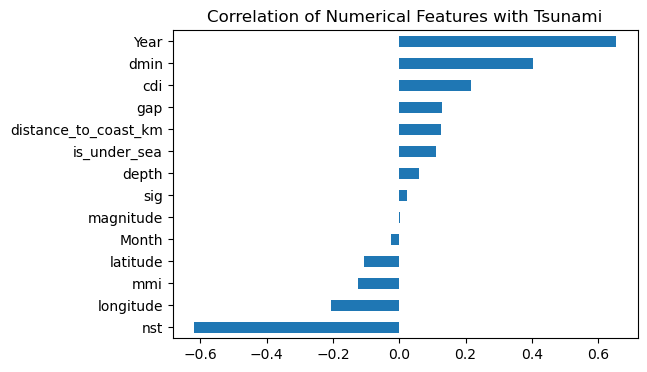

In [33]:
corr_with_target = train_df[numerical_features + ['tsunami']].corr()['tsunami']
corr_with_target = corr_with_target.drop('tsunami')

corr_with_target.sort_values().plot(kind='barh', figsize=(6, 4))
plt.title("Correlation of Numerical Features with Tsunami")
plt.show()

In [13]:
aly.alt.data_transformers.enable('vegafusion')

aly.dist(train_df, color='tsunami', mark='area')

alt.ConcatChart(...)

Key takeaways from EDA prior to modeling:
- It seems like there is a lack of records in tsunami before Year 2013. Since this is likely to be due to no data being recorded before 2013, we propose to get rid of year in the model. Year appears correlated simply due to missing tsunami data pre-2013, not causal effect.
- Tsunami is not seasonal, so Month should never be included in the model. It is safe to drop it.
- Numerical features which have higher correlation values with tsunami target such as cdi, dmin, , gap, and distance_to_coast seem to be have predictive power in classifying whether a tsunami happens or not. For others, they should still be included in the model. When they are combined with other features, they might have predictive power too.
- All the numerical features will go through StandardScaler transformation while the categorical features such as is_under_sea and PlateName will be transformed using OneHotEncoder.

## 6. Machine Learning Model Selection

In [14]:
#Function pulled from Lab 2 of DSCI571 MDS UBC, to easily extract and retract the mean and std values
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [15]:
X_train = train_df.drop(["tsunami"], axis=1)
y_train = train_df['tsunami']

numerical_cols = ['magnitude', 'depth', 'distance_to_coast_km', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap']
categorical_cols = ['is_under_sea','PlateName']

col_transformer = make_column_transformer(
    (StandardScaler(), numerical_cols),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("drop", ['latitude', 'longitude', 'Month', 'Year'])
    )

models = {
    "dummy": DummyClassifier(random_state=123),
    "Decision Tree": DecisionTreeClassifier(random_state=123),
    "KNN": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=123),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=123),
    "Random Forest Classifier": RandomForestClassifier(max_depth=10, random_state=123),
}

results_dict = {}

for model in models:
  pipeline = make_pipeline(col_transformer, models[model])

  results_dict[model] = mean_std_cross_val_scores(
                                    pipeline,
                                    X_train,
                                    y_train,
                                    cv=5,
                                    return_train_score=True)

results_df = pd.DataFrame(results_dict).T
results_df

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.000),0.001 (+/- 0.000),0.611 (+/- 0.004),0.611 (+/- 0.001)
Decision Tree,0.004 (+/- 0.001),0.001 (+/- 0.000),0.813 (+/- 0.057),1.000 (+/- 0.000)
KNN,0.002 (+/- 0.000),0.025 (+/- 0.052),0.837 (+/- 0.036),0.889 (+/- 0.012)
RBF SVM,0.005 (+/- 0.001),0.003 (+/- 0.000),0.843 (+/- 0.041),0.892 (+/- 0.009)
Naive Bayes,0.002 (+/- 0.000),0.001 (+/- 0.000),0.534 (+/- 0.029),0.549 (+/- 0.014)
Logistic Regression,0.006 (+/- 0.004),0.001 (+/- 0.000),0.857 (+/- 0.040),0.880 (+/- 0.011)
Random Forest Classifier,0.054 (+/- 0.001),0.003 (+/- 0.000),0.870 (+/- 0.040),0.967 (+/- 0.007)


Based on the scores obtained from 7 different models, the 3 best performing models are RBF SVM, Logistic Regression, and Random Forest Classifier, so these 3 models will be used for hyperparameter optimization. The model that achieves the highest score after hyperparameterization will be chosen to predict tsunami.

## 7. Hyperparameter Optimization

In [16]:
pipeline_lr = make_pipeline(col_transformer,
    LogisticRegression(max_iter=5000, random_state=123)
)

pipeline_svm = make_pipeline(col_transformer,
    SVC(kernel="rbf", probability=True, random_state=123)
)

pipeline_rf = make_pipeline(col_transformer,
    RandomForestClassifier(random_state=123)
)

In [17]:
param_dist_lr = {
    "logisticregression__C": loguniform(1e-3, 1e3),
    "logisticregression__solver": ["lbfgs", "saga"],
}

param_dist_svm = {
    "svc__C": loguniform(1e-3, 1e3),
    "svc__gamma": loguniform(1e-4, 1e-1),
}

param_dist_rf = {
    "randomforestclassifier__n_estimators": range(10,50),
    "randomforestclassifier__max_depth": range(1,20),
}

In [18]:
rs_lr = RandomizedSearchCV(
    estimator=pipeline_lr,
    param_distributions=param_dist_lr,
    n_iter=30,
    cv=5,
    random_state=123,
    n_jobs=-1
)

rs_svm = RandomizedSearchCV(
    estimator=pipeline_svm,
    param_distributions=param_dist_svm,
    n_iter=30,
    cv=5,
    random_state=123,
    n_jobs=-1
)

rs_rf = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=30,
    cv=5,
    random_state=123,
    n_jobs=-1
)

In [19]:
rs_lr.fit(X_train, y_train)
rs_svm.fit(X_train, y_train)
rs_rf.fit(X_train, y_train)

,estimator,Pipeline(step..._state=123))])
,param_distributions,"{'randomforestclassifier__max_depth': range(1, 20), 'randomforestclassifier__n_estimators': range(10, 50)}"
,n_iter,30
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,123
,error_score,nan


In [20]:
tuning_results = pd.DataFrame({
    "Model": ["Logistic Regression", "RBF SVM", "RandomForest"],
    "Best ROC-AUC": [rs_lr.best_score_, rs_svm.best_score_, rs_rf.best_score_],
    "Best Params": [rs_lr.best_params_, rs_svm.best_params_, rs_rf.best_params_]
})

tuning_results

,Model,Best ROC-AUC,Best Params
0,Logistic Regression,0.857314,"{'logisticregression__C': 1.0256992909752545, ..."
1,RBF SVM,0.868307,"{'svc__C': 178.95385188099533, 'svc__gamma': 0..."
2,RandomForest,0.872027,"{'randomforestclassifier__n_estimators': 43, '..."


As seen from the table above, RandomForest seems to be performing the best compared to other models. Therefore, RandomForest with the best parameters will be chosen as the best fit model for tsunami prediction. 

Random Forest seems to perform better compared to other models. Generally, tsunami is a natural phenomenon which is non-linear and likely to be triggered by a threshold-based process influenced by geophysical processes such as distance from coast, under-the-sea earthquakes, certain tectonic plates, etc. The engineered features in this project (distance-to-coast, under-sea classification, plate membership) create complex interactions that linear models and simple algorithms cannot capture well. Random Forest is known for its robustness to non-linear relationships and its ability to handle both numerical and categorical inputs. 

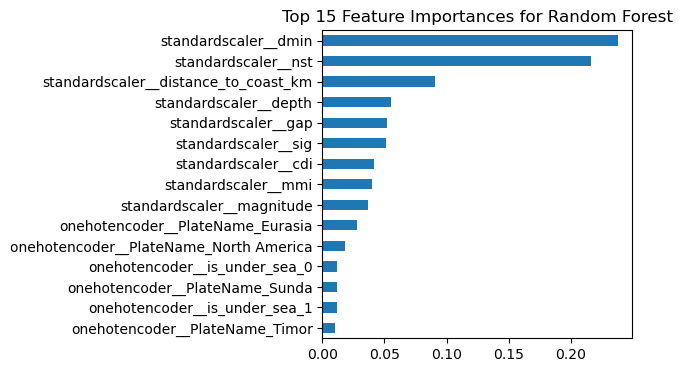

In [21]:
# Plot top 15 feature importances for Random Forest 
# Get Feature names
fitted_ct = rs_rf.best_estimator_.named_steps["columntransformer"]
feature_names = fitted_ct.get_feature_names_out()

# Get Feature importances
rf_model = rs_rf.best_estimator_.named_steps["randomforestclassifier"]
importances = pd.Series(rf_model.feature_importances_, index=feature_names)

# Plot Feature importances
importances.sort_values().tail(15).plot(kind='barh', figsize=(4, 4))
plt.title("Top 15 Feature Importances for Random Forest")
plt.show()

Key Insights
- Best model: **Random Forest Classifier**
- Best CV ROC-AUC: **0.872**
- Key feature importance insights: distance_to_coast_km, depth, magnitude, plate membership.
- The final model is robust and interpretable, consistent with the geophysical processes of earthquakes and tsunami.

## 8. Final Model Performance on Test Set

In [34]:
# Similarly transforming test set 

# Load Natural Earth low-res land polygons via geodatasets
world_path = geodatasets.get_path("naturalearth.land")
land = gpd.read_file(world_path)

# Convert your lat/lon into point geometry
test_df['geometry'] = test_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Make GeoDataFrame
gdf = gpd.GeoDataFrame(test_df, geometry='geometry', crs="EPSG:4326")

# Spatial join: which points intersect land?
joined = gpd.sjoin(gdf, land, how='left', predicate='intersects')

# If land data missing → ocean
test_df['is_under_sea'] = joined['featurecla'].isna().astype(int)

# Drop geometry if not needed
test_df = test_df.drop(columns=['geometry'])
test_df["distance_to_coast_km"] = test_df.apply(compute_distance_to_coast, axis=1)
test_df

,id,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,is_under_sea,distance_to_coast_km,PlateName
0,0,6.9,2,3,733,0,4.051,9.0,596.400,-19.7819,-178.2440,2016,9,1,423.613661,Australia
1,1,6.5,7,8,1297,0,2.360,15.0,29.000,-22.6784,25.1558,2017,4,0,905.003572,Africa
2,2,7.2,7,7,803,494,0.000,20.4,120.000,-15.5950,167.6800,2007,8,1,47.986237,New Hebrides
3,3,6.5,6,6,654,0,1.640,21.0,36.000,-10.3506,161.3350,2017,1,1,7.109533,Pacific
4,4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.2780,2022,11,1,873.490473,Australia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,230,6.9,7,5,747,0,1.205,21.0,35.000,0.5126,126.1890,2019,7,1,143.780160,Birds Head
231,231,7.3,8,7,921,0,3.713,19.0,165.490,-7.5924,127.5810,2021,12,1,93.913127,Timor
232,232,6.8,5,6,717,0,0.791,28.0,15.460,-1.8146,122.5800,2019,4,1,39.231760,Molucca Sea
233,233,6.9,3,4,735,0,2.785,18.0,115.000,-31.7447,-179.3730,2018,9,1,1851.740231,Kermadec


In [23]:
# Load Natural Earth land polygons
land_path = geodatasets.get_path("naturalearth.land")
land = gpd.read_file(land_path)

# Convert to coastline by taking the boundary
coast = land.boundary

# Project to world mercator (meters)
coast = coast.to_crs(epsg=3395)

test_df["distance_to_coast_km"] = test_df.apply(compute_distance_to_coast, axis=1)

In [24]:
gdf_test = gpd.GeoDataFrame(
    test_df,
    geometry=gpd.points_from_xy(test_df["longitude"], test_df["latitude"]),
    crs="EPSG:4326"
)

test_df = gpd.sjoin(gdf_test, plates, predicate="within", how="left")
test_df = test_df.drop(columns=['geometry', 'index_right','LAYER', 'Code'])
test_df

,id,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,is_under_sea,distance_to_coast_km,PlateName
0,0,6.9,2,3,733,0,4.051,9.0,596.400,-19.7819,-178.2440,2016,9,1,423.613661,Australia
1,1,6.5,7,8,1297,0,2.360,15.0,29.000,-22.6784,25.1558,2017,4,0,905.003572,Africa
2,2,7.2,7,7,803,494,0.000,20.4,120.000,-15.5950,167.6800,2007,8,1,47.986237,New Hebrides
3,3,6.5,6,6,654,0,1.640,21.0,36.000,-10.3506,161.3350,2017,1,1,7.109533,Pacific
4,4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.2780,2022,11,1,873.490473,Australia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,230,6.9,7,5,747,0,1.205,21.0,35.000,0.5126,126.1890,2019,7,1,143.780160,Birds Head
231,231,7.3,8,7,921,0,3.713,19.0,165.490,-7.5924,127.5810,2021,12,1,93.913127,Timor
232,232,6.8,5,6,717,0,0.791,28.0,15.460,-1.8146,122.5800,2019,4,1,39.231760,Molucca Sea
233,233,6.9,3,4,735,0,2.785,18.0,115.000,-31.7447,-179.3730,2018,9,1,1851.740231,Kermadec


In [25]:
# 1. Use the tuned Random Forest model
best_model = rs_rf.best_estimator_

# 2. Prepare test features
X_test = test_df.drop(["id"], axis=1)

# 3. Predict probabilities
test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 4. Predict classes
test_pred_class = best_model.predict(X_test)

# 5. Make submission
submission = pd.DataFrame({
    "id": test_df["id"],
    "tsunami": test_pred_class
})

# 6. Save submission
submission.to_csv("submission_Nov23.csv", index=False)

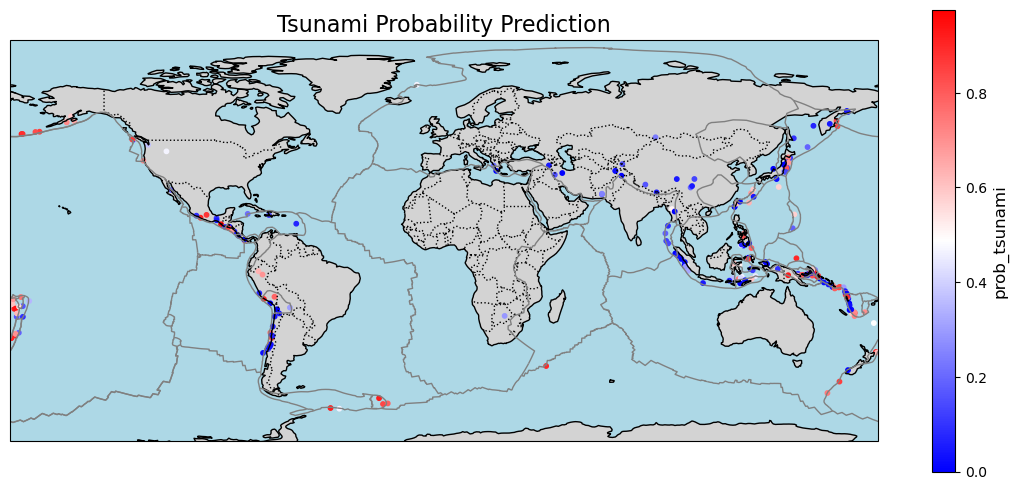

In [35]:
prediction_df = pd.DataFrame({
    "id": test_df["id"],
    "tsunami": test_pred_class,
    "prob_tsunami": test_pred_proba
})

merged_test_df = pd.merge(test_df, prediction_df, on='id', how='inner')
# Visualize the results
plot_map_numeric(merged_test_df, "prob_tsunami", lon_col="longitude", lat_col="latitude",
                     cmap="bwr", markersize=10, title="Tsunami Probability Prediction")

The map above shows the probability of whether a tsunami is likely to happen to occur after an earthquake based on the best-fit model. If the probability is higher than 0.5, the model classifies it as "yes". In contrast, if the probability is lower than 0.5, the model classifies it as "no".

## 9. Conclusion & Future Work